In [373]:
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import math
from IPython.display import clear_output
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
#%matplotlib notebook
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import cProfile
import pstats
import io
from pstats import SortKey
import random
import pandas_ta as ta

In [374]:
nifty5_org = pd.read_csv('NEW_Cleaned_Nifty50_5min.csv')
nifty5_org['EMA']=nifty5_org['Close'].ewm(span=5, adjust=False).mean()
nifty5_org['Supertrend'] = ta.supertrend(nifty5_org['High'], nifty5_org['Low'], nifty5_org['Close'],length=1,multiplier=2)['SUPERT_1_2.0']

In [472]:
tl=75
nifty5=nifty5_org[::int(75/tl)]
nifty5.reset_index(drop=True,inplace=True)

c1 = pd.DataFrame(columns=['Date', 'Number of trades'])
c1['Date'] = nifty5['Date']
c2 = pd.DataFrame(columns=['Date', 'Time','Balance','BoughtAt','SoldAt','Profloss'])
c2['Date'] = nifty5['Date']
c2['Time'] = nifty5['Time']
c1['Number of trades']=0
c2['BoughtAt'] = 0
c2['SoldAt'] = 0
c2['Profloss'] = 0
# mins = 5
# tl=int(375/mins)

pp=[]
ll=[]

pn=0
ln=0

b=1807
a=0
trade=0.0
perctgt=0.002
mintgt=0.0005

def sell(i,j,tgt,slp):
    global pn,ln,tl,slip,leverage,n,perctgt,stoplossval
    k=j+1
    for k in range(j+1,tl):
        if nifty5['Low'][i*tl+k]<tgt:            
            pn+=1
            c2.at[i*tl+k,'BoughtAt'] = tgt
            c2.at[i*tl+k,'Profloss'] = n*(slp-tgt)*leverage-nifty5['Close'][i*tl+k]*slip
            #print('1 On {}:{}; Bought at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[i*tl+k,'Date'],c2.loc[i*tl+k,'Time'],c2.loc[i*tl+k,'BoughtAt'],c2.loc[i*tl+k,'SoldAt'],c2.loc[i*tl+k,'Profloss']))
            return k
        if nifty5['Close'][i*tl+k]>nifty5['Supertrend'][i*tl+k]:
            ln+=1
            c2.at[i*tl+k,'BoughtAt'] = nifty5['Close'][i*tl+k]
            c2.at[i*tl+k,'Profloss'] = n*(slp-nifty5['Close'][i*tl+k])*leverage-nifty5['Close'][i*tl+k]*slip
            if ((nifty5['Supertrend'][i*tl+k-1]*(1+perctgt)-nifty5['Close'][i*tl+k])>mintgt*nifty5['Supertrend'][i*tl+k-1]):
                #print('2 On {}:{}; Bought twice at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[i*tl+k,'Date'],c2.loc[i*tl+k,'Time'],c2.loc[i*tl+k,'BoughtAt'],c2.loc[i*tl+k,'SoldAt'],c2.loc[i*tl+k,'Profloss']))
                return buy(i,k,nifty5['Supertrend'][i*tl+k-1]*(1+perctgt),nifty5['Close'][i*tl+k])
            else:
                return k
        if nifty5['Close'][i*tl+k]>slp*(1+stoplossval):
            ln+=1
            c2.at[i*tl+k,'BoughtAt'] = slp*(1+stoplossval)
            c2.at[i*tl+k,'Profloss'] = n*(slp-slp*(1+stoplossval))*leverage-nifty5['Close'][i*tl+k]*slip    
            return k
    c2.at[i*tl+k,'BoughtAt'] = nifty5['Close'][i*tl+k]
    c2.at[i*tl+k,'Profloss'] = n*(slp-nifty5['Close'][i*tl+k])*leverage-nifty5['Close'][i*tl+k]*slip
    #print('3 On {}:{}; Bought at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[i*tl+k,'Date'],c2.loc[i*tl+k,'Time'],c2.loc[i*tl+k,'BoughtAt'],c2.loc[i*tl+k,'SoldAt'],c2.loc[i*tl+k,'Profloss']))
    if c2.at[i*tl+k,'Profloss']>0:
        pn+=1
    else:
        ln+=1
    return k

def buy(i,j,tgt,byp):
    global pn,ln,tl,slip,leverage,n,perctgt,stoplossval
    k=j+1
    for k in range(j+1,tl):
        if nifty5['High'][i*tl+k]>tgt:
            pn+=1
            c2.at[i*tl+k,'SoldAt'] = tgt
            c2.at[i*tl+k,'Profloss'] = n*(tgt-byp)*leverage-nifty5['Close'][i*tl+k]*slip
            #print('4 On {}:{}; Sold at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[i*tl+k,'Date'],c2.loc[i*tl+k,'Time'],c2.loc[i*tl+k,'BoughtAt'],c2.loc[i*tl+k,'SoldAt'],c2.loc[i*tl+k,'Profloss']))
            return k
        if nifty5['Close'][i*tl+k]<nifty5['Supertrend'][i*tl+k]:            
            ln+=1
            c2.at[i*tl+k,'SoldAt'] = nifty5['Close'][i*tl+k]
            c2.at[i*tl+k,'Profloss'] = n*(nifty5['Close'][i*tl+k]-byp)*leverage-nifty5['Close'][i*tl+k]*slip
            if ((nifty5['Close'][i*tl+k]-nifty5['Supertrend'][i*tl+k-1]*(1-perctgt))>mintgt*nifty5['Supertrend'][i*tl+k-1]):
                #print('5 On {}:{}; Sold twice at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[i*tl+k,'Date'],c2.loc[i*tl+k,'Time'],c2.loc[i*tl+k,'BoughtAt'],c2.loc[i*tl+k,'SoldAt'],c2.loc[i*tl+k,'Profloss']))
                return sell(i,k,nifty5['Supertrend'][i*tl+k-1]*(1-perctgt),nifty5['Close'][i*tl+k])
            else:
                return k
        if nifty5['Close'][i*tl+k]<byp*(1-stoplossval):
            ln+=1
            c2.at[i*tl+k,'SoldAt'] = byp*(1-stoplossval)
            c2.at[i*tl+k,'Profloss'] = n*(byp*(1-stoplossval)-byp)*leverage-nifty5['Close'][i*tl+k]*slip    
            return k
    c2.at[i*tl+k,'SoldAt'] = nifty5['Close'][i*tl+k]
    c2.at[i*tl+k,'Profloss'] = n*(nifty5['Close'][i*tl+k]-byp)*leverage-nifty5['Close'][i*tl+k]*slip
    #print('6 On {}:{}; Sold at:{:.2f} and Sold at:{:.2f} for a trade of:{:.2f}'.format(c2.loc[i*tl+k,'Date'],c2.loc[i*tl+k,'Time'],c2.loc[i*tl+k,'BoughtAt'],c2.loc[i*tl+k,'SoldAt'],c2.loc[i*tl+k,'Profloss']))
    if c2.at[i*tl+k,'Profloss']>0:
        pn+=1
    else:
        ln+=1
    return k

for proftolossratio in [1.5]:
    for stoplossval in [0.1]:
        daysconsidered=1800
        global pn,ln
           
        c2.at[a*tl, 'Balance'] = round(1*nifty5['Open'][a*tl],-4)

        slippage=0

        ini=c2.at[a*tl, 'Balance']
        balance=ini
        tgt=0.0
        sl=0.0
        profit=0.0
        leverage=15
        slip=slippage/100
        
        for i in range(a,b):
            n=max(1,math.floor(balance/nifty5['Open'][i*tl]))
            profit=0
            k=0
            if i>a:
                c2.at[i*tl, 'Balance'] = c2.loc[i*tl-1, 'Balance']
            for j in range(1,nifty5.Time.nunique()):
                if j<k+1:
                    continue  

                if j!=k:
                    c2.at[i*tl+j, 'Balance'] = c2.loc[i*tl+j-1, 'Balance']

                if min(nifty5['Open'][i*tl+j-1],nifty5['Close'][i*tl+j-1])>nifty5['Supertrend'][i*tl+j-1] and j<(nifty5.Time.nunique()-1):
                    if (nifty5['Close'][i*tl+j]-nifty5['Supertrend'][i*tl+j-1]*(1-perctgt))>mintgt*nifty5['Supertrend'][i*tl+j-1] and nifty5['Close'][i*tl+j]<nifty5['Supertrend'][i*tl+j-1]:
                        slp=nifty5['Close'][i*tl+j]
                        tgt=nifty5['Supertrend'][i*tl+j-1]*(1-perctgt)
                        #print('Sent sell command from main func on {}:{}'.format(nifty5['Date'][i*tl+j],nifty5['Time'][i*tl+j]))
                        k = sell(i,j,tgt,slp)                       
                        for j1 in range(j,k+1):
                            c2.at[i*tl+j1, 'Balance'] = c2.loc[i*tl+j1-1, 'Balance']
                        c2.at[i*tl+k,'Balance'] = c2.loc[i*tl+k,'Balance']+c2['Profloss'][i*tl:(i+1)*tl].sum()
                        c2.at[i*tl+j,'SoldAt'] = slp
                        continue 

                if max(nifty5['Open'][i*tl+j-1],nifty5['Close'][i*tl+j-1])<nifty5['Supertrend'][i*tl+j-1] and j<(nifty5.Time.nunique()-1):
                    if (nifty5['Supertrend'][i*tl+j-1]*(1+perctgt)-nifty5['Close'][i*tl+j])>mintgt*nifty5['Supertrend'][i*tl+j-1] and nifty5['Close'][i*tl+j]>nifty5['Supertrend'][i*tl+j-1]:
                        byp=nifty5['Close'][i*tl+j]
                        tgt=nifty5['Supertrend'][i*tl+j-1]*(1+perctgt)
                        #print('Sent buy command from main func on {}:{}'.format(nifty5['Date'][i*tl+j],nifty5['Time'][i*tl+j]))
                        k = buy(i,j,tgt,byp)                       
                        for j1 in range(j,k+1):
                            c2.at[i*tl+j1, 'Balance'] = c2.loc[i*tl+j1-1, 'Balance']
                        c2.at[i*tl+k,'Balance'] = c2.loc[i*tl+k,'Balance']+c2['Profloss'][i*tl:(i+1)*tl].sum()
                        c2.at[i*tl+j,'BoughtAt'] = byp
                        continue                         
                        
            balance = c2.loc[i*tl+j, 'Balance']
            if balance<0:
                print(c2['Date'][i*tl+j])
                print('Total Loss')
                break

        res=(balance-ini)/ini
        Roll_Max = c2['Balance'][a*tl:b*tl:tl].cummax()
        Daily_Drawdown = c2['Balance'][a*tl:b*tl:tl]/Roll_Max - 1.0
        Max_Daily_Drawdown = Daily_Drawdown.cummin()
        numberoftrades=(ln+pn)/(b-a)
        max_drawdown=100*min(np.array(Max_Daily_Drawdown))
        if (ln+pn)>0:
            pop=100*pn/(ln+pn)
        else:
            pop=0
        net_return=res*100
        if res>0:
            annual_return=100*(pow(10,math.log(1+res,10)/(daysconsidered/234))-1)
        else:
            annual_return=0
        pn=0
        ln=0
        print('Max Drawdown: {:.2f}% , Probability of profit: {:.2f}% and Number of trades per day: {:.2f}'.format(max_drawdown,pop,numberoftrades))
        print('Net return: {:.2f}%, annualized: {:.2f}% stoplossval:{:.2f}%\n\n'.format(net_return,annual_return,stoplossval*100))
#         profloss = np.array(c2['Profloss'])
#         profloss[ profloss==0 ] = np.nan
#         c2['Profloss'] = profloss 
#         print(c2[c2['Profloss']>0]['Profloss'].mean())
#         print(c2[c2['Profloss']<0]['Profloss'].mean())

for i in range(len(c2['Balance'])):
    if math.isnan(c2.loc[i,'Balance']):
        c2.loc[i,'Balance']=c2.loc[i-1,'Balance']

12-05-2022
Total Loss
Max Drawdown: -83.69% , Probability of profit: 47.59% and Number of trades per day: 4.18
Net return: -4746652.92%, annualized: 0.00% stoplossval:10.00%




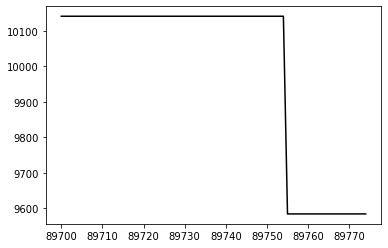

In [404]:
plt.plot(c2[c2['Date']=='13-03-2020']['Balance'],'k',label='5 minute Balance')

<Figure size 7200x4800 with 0 Axes>

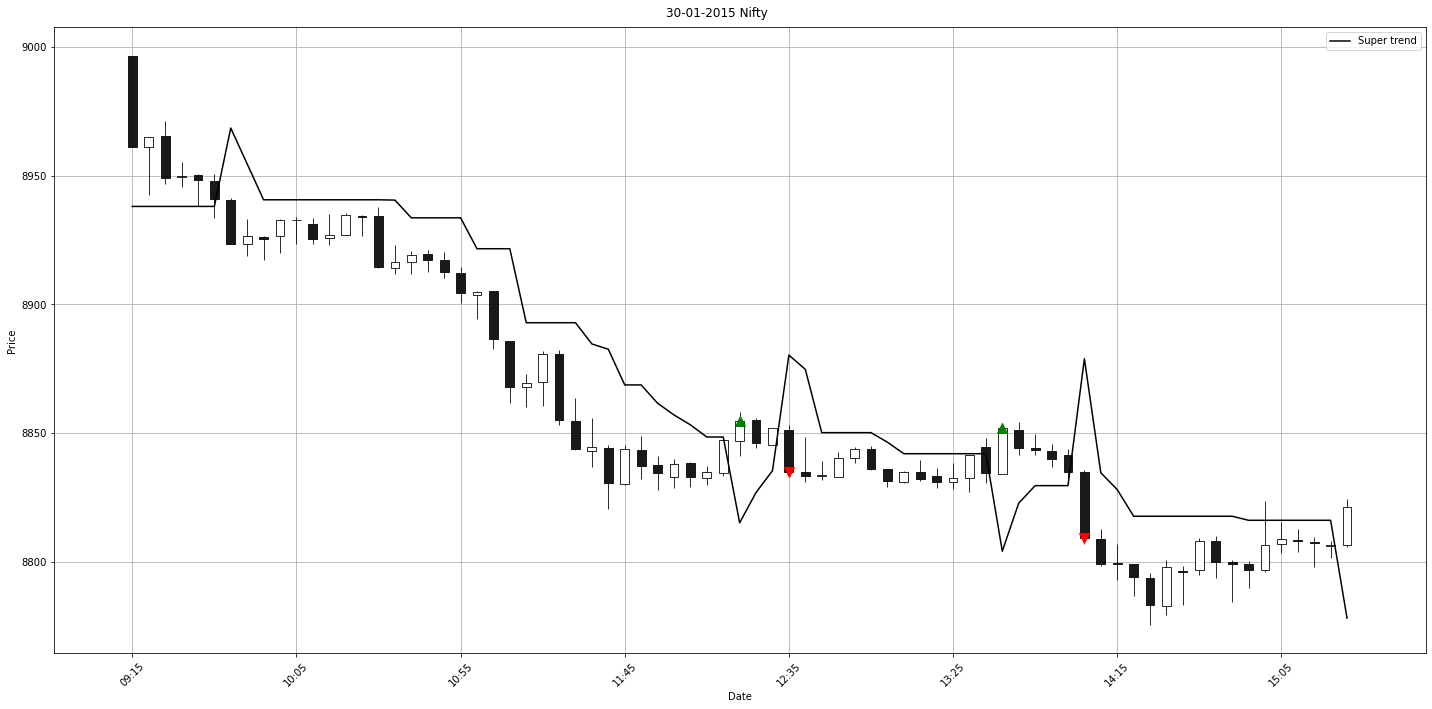

In [466]:
trading_days = list(c2[~np.isnan(c2['BoughtAt'])]['Date'])
day=random.randint(1, len(trading_days)-1)
f=1
#a=int(c2[c2['Date']=='11-01-2018'].index[0]/tl)
a=int(c2[c2['Date']==trading_days[day]].index[0]/tl)
b=1
b+=a
plotnifty=nifty5.iloc[a*tl:b*tl:f, :]
plotnifty.index= pd.to_datetime(plotnifty['Date']+' '+plotnifty['Time'])
plotnifty.drop('Date',axis=1,inplace=True)
plotnifty.drop('Time',axis=1,inplace=True)
buytr = np.array(c2['BoughtAt'])
selltr = np.array(c2['SoldAt'])
buytr[ buytr==0 ] = np.nan
selltr[ selltr==0 ] = np.nan
c2['BoughtAt'] = buytr 
c2['SoldAt'] = selltr
#Creating Subplots
plt.figure(dpi=1200)
fig, ax = plt.subplots(figsize=(20,10))
mc = mpf.make_marketcolors(up='w',down='k')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(plotnifty[:], type='candle',style=s,ax=ax,warn_too_much_data=2000)
plt.plot(plotnifty['Supertrend'].values,'k',label='Super trend')
#plt.plot(c2['Balance'][a*75::f].values,'b',label='5 minute Balance')
plt.plot(c2['BoughtAt'][a*tl:b*tl:f].values,'g^',markersize=10)
plt.plot(c2['SoldAt'][a*tl:b*tl:f].values,'rv',markersize=10)
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle('Daily Candlestick Chart of nifty')
fig.suptitle(str(nifty5.iloc[a*tl:b*tl:f, :]['Date'].iat[-1])+' '+'Nifty')
fig.tight_layout()
plt.grid()
plt.legend()
#c2[c2['Date']=='12-01-2018'].to_csv('test.csv')
#c2[c2['Date']==trading_days[day]].to_csv('test.csv')

<Figure size 7200x4800 with 0 Axes>

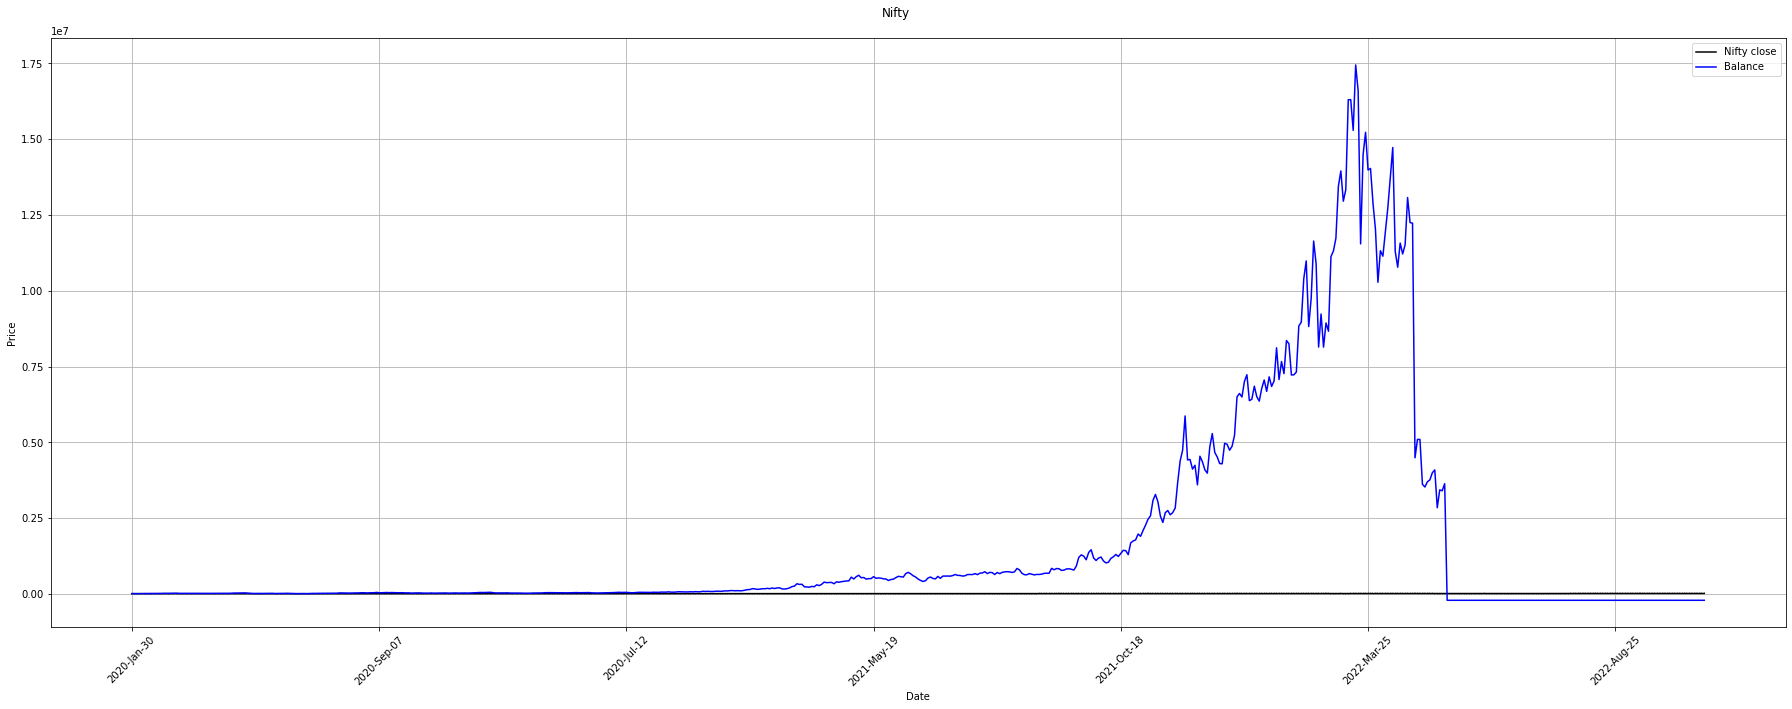

In [514]:
f=75
a=234*5
b=234*8
plotnifty=nifty5[a*tl:b*tl:f]
plotnifty.index= pd.to_datetime(plotnifty['Date']+' '+plotnifty['Time'])
plotnifty.drop('Date',axis=1,inplace=True)
plotnifty.drop('Time',axis=1,inplace=True)
plotbal=c2['Balance'][a*tl:b*tl:f]
fact=plotbal.iloc[0]/plotnifty['EMA'].iloc[0]
plotbal=plotbal/fact
#Creating Subplots
plt.figure(dpi=1200)
fig, ax = plt.subplots(figsize=(25,10))
mc = mpf.make_marketcolors(up='w',down='k')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(plotnifty[:], type='candle',style=s,ax=ax,warn_too_much_data=2000)
plt.plot(plotnifty['EMA'].values,'k',label='Nifty close')
plt.plot(plotbal.values,'b',label='Balance')
#plt.plot(np.divide(c2['Balance'][a*tl:b*tl:f].values[1:], np.diff(c2['Balance'][a*tl:b*tl:f])) ,'r',label='ratio')
#plt.plot(np.diff(c2['Balance'][a*tl:b*tl:f]) ,'g',label='differential')
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle('Daily Candlestick Chart of nifty')
fig.suptitle('Nifty')
fig.tight_layout()
plt.grid()
plt.legend()
#plt.savefig(nifty5.iloc[a*tl:b*tl:f, :]['Date'].iat[-1])

In [300]:
np.diff(c2['Balance'])

array([nan, nan, nan, ..., 0.0, 0.0, 4729.302000000025], dtype=object)

<Figure size 7200x4800 with 0 Axes>

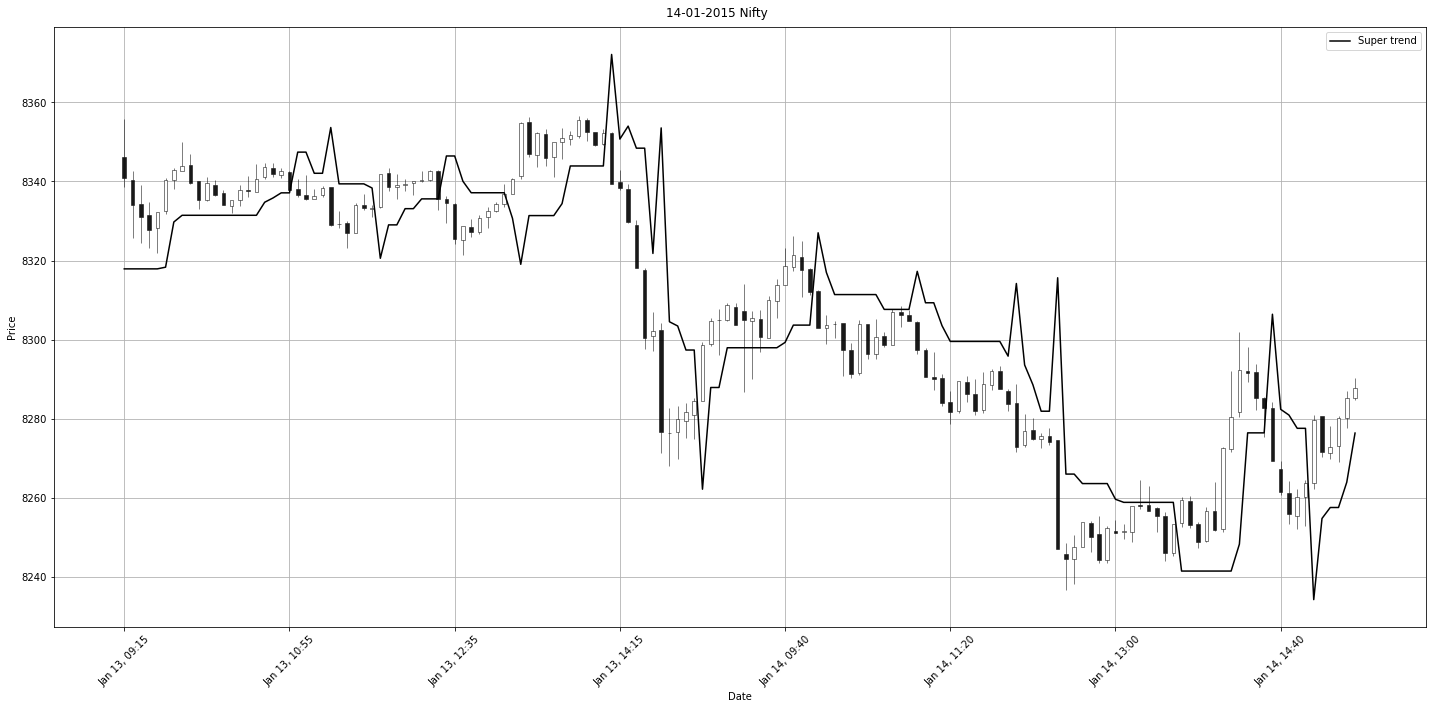

In [152]:
f=1
a=1
b=3
plotnifty=nifty5.iloc[a*tl:b*tl:f, :]
plotnifty.index= pd.to_datetime(plotnifty['Date']+' '+plotnifty['Time'])
plotnifty.drop('Date',axis=1,inplace=True)
plotnifty.drop('Time',axis=1,inplace=True)
#Creating Subplots
plt.figure(dpi=1200)
fig, ax = plt.subplots(figsize=(20,10))
mc = mpf.make_marketcolors(up='w',down='k')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(plotnifty[:], type='candle',style=s,ax=ax,warn_too_much_data=2000)
plt.plot(plotnifty['Supertrend'].values,'k',label='Super trend')
#plt.plot(c2['Balance'][a*75::f].values,'b',label='5 minute Balance')
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle('Daily Candlestick Chart of nifty')
fig.suptitle(str(nifty5.iloc[a*tl:b*tl:f, :]['Date'].iat[-1])+' '+'Nifty')
fig.tight_layout()
plt.grid()
plt.legend()

<Figure size 7200x4800 with 0 Axes>

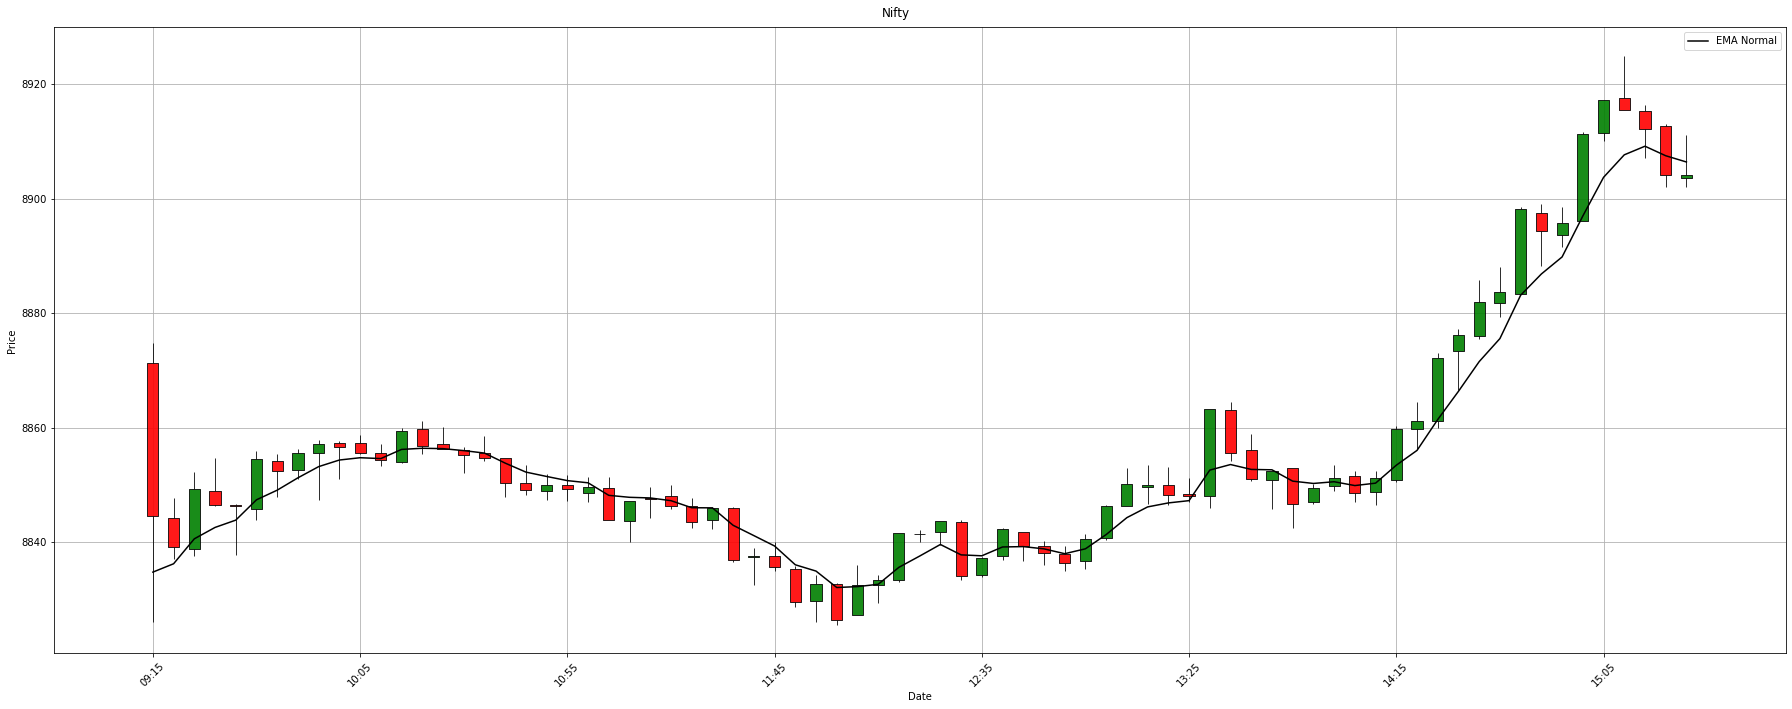

In [139]:
f=1
a=7
a+=1
b=1
b+=a
plotnifty=nifty5.iloc[a*75:b*75:f, :]
plotnifty.index= pd.to_datetime(plotnifty['Date']+' '+plotnifty['Time'])
plotnifty.drop('Date',axis=1,inplace=True)
plotnifty.drop('Time',axis=1,inplace=True)
buytr = np.array(c2['BoughtAt'])
selltr = np.array(c2['SoldAt'])
buytr[ buytr==0 ] = np.nan
selltr[ selltr==0 ] = np.nan
c2['BoughtAt'] = buytr 
c2['SoldAt'] = selltr
#Creating Subplots
plt.figure(dpi=1200)
fig, ax = plt.subplots(figsize=(25,10))
mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(plotnifty[:], type='candle',style=s,ax=ax,warn_too_much_data=2000)
plt.plot(plotnifty['EMA'].values,'k',label='EMA Normal')
#plt.plot(c2['Balance'][a*75::f].values,'b',label='5 minute Balance')
plt.plot(c2['BoughtAt'][a*75:b*75:f].values,'k^')
plt.plot(c2['SoldAt'][a*75:b*75:f].values,'bv')
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
#fig.suptitle('Daily Candlestick Chart of nifty')
fig.suptitle('Nifty')
fig.tight_layout()
plt.grid()
plt.legend()
plt.savefig(nifty5.iloc[a*75:b*75:f, :]['Date'].iat[-1])